# 強化学習 3日目 @ Summer School 数理物理 2021
## Deep Q-network (DQN) の実装
- タスクはOpenAIGymのCartPole
- 連続状態、２行動の制御問題
- Kerasを用いる
- RLライブラリを使用しない -> chainerRLを利用したノートブックDQN_OpenAIGym_chainerRL.ipynbもある
***
Tetsuro Morimura, 2021

# 準備

### Colabランタイムの設定
- 始める前に、「ランタイム→ランタイムのタイプの変更」から，アクセラレーターをGPUに設定する

### TensorFlowのversionの指定
  - 2.x (2.0.1はOKだけど、2.3.0はNG） だと落ちるので、1.xを指定する

In [ ]:
%tensorflow_version 1.x
#!pip3 uninstall tensorflow
#!pip3 install tensorflow==2.0.1

TensorFlow 1.x selected.


### モジュールのインポート

In [ ]:
# essential models
import gym
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

# modules for movie
from IPython import display as ipythondisplay
import glob
import io
import base64
!apt-get -qq -y install xvfb freeglut3-dev ffmpeg> /dev/null
!pip install pyvirtualdisplay

from pyvirtualdisplay import Display
import os
print(tf.__version__)

1.15.2


# 環境の設定

### ゲーム環境の設定

In [ ]:
env = gym.make('CartPole-v0') ## ゲーム環境の設定（棒制御）

### 動画の記録、再生のための設定

- 動画関連のメソッドの定義

In [ ]:
def wrap_env(env):
    # force=True：以前のモニタファイルを自動的にクリア
    env = gym.wrappers.Monitor(env, './video', force=True)
    return env

def show_video():
    mp4list = glob.glob('video/*.mp4')
    #print(len(mp4list))
    if len(mp4list) > 0:
        for m in range(len(mp4list)):
            mp4 = mp4list[m]
            video = io.open(mp4, 'r+b').read()
            encoded = base64.b64encode(video)
            ipythondisplay.display(ipythondisplay.HTML(data='''
                <video alt="test" autoplay loop controls style="height: 300px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else: 
          print("Could not find video")

- ディスプレイの設定

In [ ]:
display = Display(visible=0, size=(1024, 768))
display.start()

#os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)

### 動作確認

- 観測空間，行動空間の確認

In [ ]:
print('observation space:', env.observation_space) ## 観測空間のチェック
print('action space:', env.action_space) ## 行動空間のチェック

observation space: Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
action space: Discrete(2)


- 環境を初期化して、初期観測を確認

In [ ]:
obs = env.reset() ## 環境の初期化
#env.render() ## 学習過程のレンダリング関数
print('initial observation:', obs)

initial observation: [-0.02651674 -0.03557375  0.00752968 -0.0288766 ]


- エピソード生成（行動は乱択）

In [ ]:
obs = env.reset() 

done = False
t    = 0
while not done:
  action = env.action_space.sample()    # ランダムな行動選択
  obs, r, done, info = env.step(action) # 行動を環境に入力して、次状態などを受け取る
  ## 出力の確認
  print('----------- time step {} --------'.format(t))
  print('selected action:', action)
  print('next observation:', obs)
  print('reward:', r)
  print('done:', done)
  print('info:', info)
  t += 1

----------- time step 0 --------
selected action: 1
next observation: [ 0.04316229  0.15997083  0.02814519 -0.32396558]
reward: 1.0
done: False
info: {}
----------- time step 1 --------
selected action: 0
next observation: [ 0.04636171 -0.03554034  0.02166588 -0.02254138]
reward: 1.0
done: False
info: {}
----------- time step 2 --------
selected action: 0
next observation: [ 0.0456509  -0.23096619  0.02121505  0.27689787]
reward: 1.0
done: False
info: {}
----------- time step 3 --------
selected action: 0
next observation: [ 0.04103158 -0.42638429  0.02675301  0.5761958 ]
reward: 1.0
done: False
info: {}
----------- time step 4 --------
selected action: 1
next observation: [ 0.03250389 -0.23164736  0.03827693  0.29205939]
reward: 1.0
done: False
info: {}
----------- time step 5 --------
selected action: 1
next observation: [ 0.02787094 -0.03709148  0.04411811  0.01169   ]
reward: 1.0
done: False
info: {}
----------- time step 6 --------
selected action: 0
next observation: [ 0.02712911

- エピソードを動画に記録し、再生する

In [ ]:
n_episode = 3 # 3以上に設定しても、なぜか2エピソードしか保存されず..

# エピソードを生成し、動画を保存
envw = wrap_env(gym.make('CartPole-v0'))

for i in range(n_episode):

    observation = envw.reset()
    done = False
    total_reward = 0

    while not done:
        envw.render()
        action = env.action_space.sample()     # ランダムな行動選択
        obs, r, done, info = envw.step(action) # 行動を環境に入力して、次状態などを受け取る
        total_reward += r

    print('test episode:', i+1, 'total reward:', total_reward)

envw.close()

# 動画の再生
show_video()

# Colab上から動画を削除
#!rm video/openaigym.video.*

test episode: 1 total reward: 14.0
test episode: 2 total reward: 31.0
test episode: 3 total reward: 18.0


# エージェントの設定

### RLエージェントクラスの定義
- アブストラクトクラス

In [ ]:
## Abstract RL agent class 
class Agent():
    def __init__(self, state_space, action_space, gamma=0.9):
        self.state_space  = state_space
        self.action_space = action_space
        self.gamma        = gamma
        self.experiences  = []
        self.timestep     = 0
        self.episode      = 0

    def reset(self):
        # エージェントの初期化
        raise NotImplementedError("class is abstract.") 

    def end_episode(self):
        # エピソード終了時の処理
        raise NotImplementedError("class is abstract.") 

    def add_experience(self, state, action, reward, next_state):
        # 経験データの追加
        raise NotImplementedError("class is abstract.") 

    def policy(self, state):
        # 行動選択
        raise NotImplementedError("class is abstract.")

    def learning(self):
        # 学習
        raise NotImplementedError("class is abstract.")

### DQNエージェントクラスの実装
- Agentクラスを継承
- Q関数: DNN
- 方策: Epsilon-greedy

In [ ]:
## DQN agent (tabular version with epsilon-greedy policy)
from operator import itemgetter

class DQN(Agent):
    # 連続状態、離散行動を想定
    def __init__(self, state_space, action_space, gamma=0.9, epsilon=[100., 200.],alpha=0.001):
        super().__init__(state_space, action_space, gamma)
        self.nstate  = state_space.shape[0]
        self.naction = action_space.n
        self.epsilon = epsilon # hyper-param for e-greedy
        self.alpha   = alpha   # hyper-hparam for learning rate
        # DQN specific parameters 
        self.buffer_size        = 100000
        self.buffer_reduce_size = 500
        self.batch_size         = 1000
        self.n_hidden_unit      = 16
        # DNN for Q-value function
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(self.n_hidden_unit, activation="relu", input_dim=self.nstate))
        model.add(tf.keras.layers.Dense(self.n_hidden_unit, activation="relu"))
        model.add(tf.keras.layers.Dense(self.naction, activation="linear"))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=alpha))
        #odel.compile(loss='huber_loss', optimizer=tf.keras.optimizers.Adam(lr=alpha)) #huber_lossはなぜかうまくいかない..
        self.q_fun = model

    def reset(self):
        self.__init__(self.state_space, self.action_space, self.gamma, self.epsilon, self.alpha)

    def end_episode(self):
        self.timestep = 0
        self.episode += 1

    def add_experience(self, experience):
        self.experiences.append( experience )
        # バッファーが一杯になったら、buffer_reduce_size個の経験サンプルを乱択し、削除
        if len(self.experiences) > self.buffer_size:
            delete_index     = list(np.random.choice(self.buffer_size, self.buffer_reduce_size, replace=False))
            for i, d in enumerate(sorted(delete_index, reverse=True)):
                del self.experiences[d]
          
    def policy(self, state): #Epsilon-Greedy Agent Policy
        # epsilonの設定
        if isinstance(self.epsilon, list) != True:
            epsilon = self.epsilon
        else:
            epsilon = self.epsilon[0] / (self.episode + self.epsilon[1])
        # 行動選択
        if epsilon <= np.random.uniform():
            action = np.argmax(self.q_fun.predict([[state]]))
        else:
            action = np.random.choice(self.naction)
        return action

    def learning(self):
        # no learn if buffer size is smaller than half of "batch_size"
        if 2*len(self.experiences) < self.batch_size:
            return
        # sampling from buffer
        num_sample   = np.min([len(self.experiences)-1, self.batch_size])
        #print(num_sample, len(self.experiences), self.batch_size)
        target_index = np.random.choice(len(self.experiences), num_sample, replace=False)
        batch        = itemgetter(*target_index)(self.experiences)
        # prep traing data
        S      = np.zeros((num_sample, self.nstate))
        S_next = np.zeros((num_sample, self.nstate))
        for i, (s, _, _, s_next, _) in enumerate(batch):
            S[i]      = s
            S_next[i] = s_next
        q      = self.q_fun.predict([S],      batch_size=num_sample) 
        q_next = self.q_fun.predict([S_next], batch_size=num_sample) 
        for i, (_, a, r, _, done) in enumerate(batch):
            q[i,a] = r
            if not done: # episodeが失敗時以外は
                q[i,a] += self.gamma * np.max(q_next[i])
        # fit q_fun
        self.q_fun.fit(S, q, epochs=1, verbose=0)  # epochsは訓練データの反復回数、verbose=0は表示なしの設定

# 実験

### 実験条件の設定

In [ ]:
## Set parameters

# param for experiment
max_episode = 1000                        # num of experiments
n_timestep  = env.spec.max_episode_steps # length of episode


# param for DQN agent
gamma       = 0.98       # discounting rate
alpha       = 0.001      # for mse:0.001       # learning rate for adam
epsilon     = [5, 10]    # epsilon of e-greedy: epsilon[0]/(episode+epsilon[1])

### 学習

In [ ]:
## Learning by DQN

# prep
agent = DQN(env.observation_space, env.action_space, gamma=gamma, alpha=alpha, epsilon=epsilon)
return_list  = []
return_print = 0 
n_consecutive_success = 0



# main
print("DQN ...")
for episode in range(max_episode):

    # reset agent and env
    agent.end_episode()
    obs    = env.reset()
    ret    = 0
    n_consecutive_success += 1

    # episode start
    for t in range(n_timestep-1):
        # interaction with env
        action                    = agent.policy(obs)
        next_obs, reward, done, _ = env.step(action)
        if done:
            reward   = -100
        # update agent
        agent.add_experience([obs, action, reward, next_obs, done])
        agent.timestep += 1
        # update observation
        obs = next_obs
        # store
        ret += reward

        if done:
            n_consecutive_success = 0
            break

    # learning
    #if episode%2==0:
    agent.learning()

    # store return
    return_list.append(ret)
    # print
    return_print += ret
    if episode%5==0: 
        print( ' > episode:', episode, ', averaged return', return_print/5, ' (n_consecutive_success', n_consecutive_success, ')' )
        print('   ', agent.q_fun.predict([[agent.experiences[-1][0]]]))
        return_print = 0
       
    # check convergence (30回連続立て続けられれば、学習成功とする)
    if n_consecutive_success > 30:
        print("Successed in learning !")
        break


if episode == max_episode-1:
    print("-----> Learning failed.")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
DQN ...
 > episode: 0 , averaged return -17.6  (n_consecutive_success 0 )
    [[ 0.15743396 -0.32442623]]
 > episode: 5 , averaged return -90.0  (n_consecutive_success 0 )
    [[ 0.10535009 -0.15701996]]
 > episode: 10 , averaged return -91.0  (n_consecutive_success 0 )
    [[ 0.1857821  -0.38414466]]
 > episode: 15 , averaged return -91.0  (n_consecutive_success 0 )
    [[ 0.2115932 -0.4438283]]
 > episode: 20 , averaged return -90.8  (n_consecutive_success 0 )
    [[ 0.20271286 -0.45224285]]
 > episode: 25 , averaged return -90.2  (n_consecutive_success 0 )
    [[ 0.1493018 -0.3171897]]
 > episode: 30 , averaged return -91.8  (n_consecutive_success 0 )
    [[ 0.19923964 -0.52326554]]
 > episode: 35 , averaged return -91.4  (n_consecutive_success 0 )
    [[ 0.19179429 -0.5040302 ]]
 > episode: 40 , averaged return -92.2  (n_consecutive_success 0 )
    [[ 0.15716317 -0.34203184]]
 > episode: 45 , averaged 

- 学習曲線

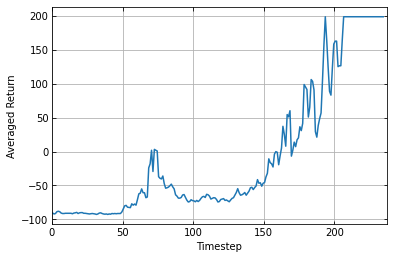

In [ ]:
## Visualization
t_lim       = len(return_list)
window_size = 3

# smooth return
v = np.ones(window_size)/window_size
smoothed_return = np.convolve( return_list, v, mode='valid')

# plot
xlim = np.array(range(window_size-1,t_lim)) - window_size/2
plt.plot(xlim, smoothed_return)
plt.xlabel('Timestep')
plt.ylabel('Averaged Return')
plt.tick_params(top = True, right = True, direction = 'in')
plt.grid(which='both')
plt.xlim(0,t_lim)
plt.show()

- テスト（学習した方策を実際に動かしてみる）

In [ ]:
n_movie = 2 # 3以上に設定しても、なぜか2エピソードしか保存されず..

# エピソードを生成し、動画を保存
envw = wrap_env(gym.make('CartPole-v0'))

for i in range(n_movie):

    obs   = envw.reset()
    done  = False
    ret   = 0

    while not done:
        envw.render()
        action = agent.policy(obs)             # 行動選択
        obs, r, done, info = envw.step(action) # 行動を環境に入力して、次状態などを受け取る
        ret += r

    print('test episode:', i+1, 'total reward:', ret)

envw.close()

# 動画の再生
show_video()

# Colab上から動画を削除
!rm video/openaigym.video.*

test episode: 1 total reward: 200.0
test episode: 2 total reward: 200.0
